In [709]:
import pandas as pd
import numpy as np
import nltk
import re
from datetime import date, datetime
import time
import matplotlib.pyplot as plt
import urllib.request
from tqdm import tqdm
import pickle
import spacy
import random
import ast
import seaborn as sns
import networkx as nx

In [386]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [710]:
tqdm.pandas()

In [4]:
pd.set_option('display.max_colwidth', -1)

In [5]:
# getting the burst timeline..
df_tweets = pd.read_csv('/home/auppal8/HexagonData_new.csv',lineterminator='\n', index_col=None)

In [405]:
df_timeline = pd.read_csv('/home/auppal8/userTimelineData.csv',lineterminator='\n',)

In [7]:
df_following = pd.read_excel('/home/auppal8/updatedfollowingData1117.xlsx', index_col=0)

In [8]:
# following data for user...
df_300 = pd.read_csv("~/Following300_1220.csv",index_col=0)

In [355]:
# getting the few labelled 
df_char = pd.read_csv("/home/auppal8/twitter_juul/input/user_characteristics.csv",index_col=0,keep_default_na=False)

In [9]:
#no of hashtags per tweet
# url and then no of url per tweet
# no of @user-mention per tweet
# percentage of retweet per user (user retweets / total no of tweets)

In [10]:
def hashtag_count(df):
    if df is not np.nan:
        hashtags = ast.literal_eval(df)
        if (hashtags is not None):
            return (len(hashtags))
        else:
            return(0)
    else:
        return(0)

In [406]:
# count no of hashtags
df_timeline['hashtags'] = df_timeline['hashtags'].progress_apply(hashtag_count)


100%|██████████| 1344182/1344182 [00:11<00:00, 121886.33it/s]

In [208]:
# find the occurence of urls
df_timeline['urls_id'] = df_timeline['tweetText'].str.findall(r'(https?://\S+)')

In [12]:
# count the no of urls per tweet
df_timeline['urls'] = df_timeline['tweetText'].str.count(r'(https?://\S+)')

In [13]:
# count no of user mentiosn per tweet
df_timeline['author_mentions'] = df_timeline['tweetText'].str.count(r'(\@\w+)')

In [26]:
# just to get avergae user mentions per user
df_user = df_timeline.groupby(df_timeline['userID']).agg({'author_mentions': 'median',
                                                          'urls' : 'median',
                                                          'retweetCount' : 'sum'})

In [33]:
total = df_user['retweetCount'].sum()
df_user['retweetCount'] = df_user['retweetCount'].apply(lambda x: (x/total) * 100)

In [41]:
df_timeline.columns

Index(['favourites_count', 'friendList', 'friendsCount', 'hashtags',
       'imageurl', 'lang', 'retweetCount', 'retweeted', 'tweetCreatedAt',
       'tweetId', 'tweetText', 'userCreatedAt', 'userDescription',
       'userFollowersCount', 'userID', 'userLocation', 'userName', 'urls',
       'author_mentions'],
      dtype='object')

In [40]:
# start with behavious characteristics
# max, min and average no of tweets per day  --done
# max, min time , average time interval between consecutive tweets --done
# total no of tweets
# no of unique urls

In [48]:
df_timeline['tweetCreatedAt'] = pd.to_datetime(df_timeline.tweetCreatedAt)

In [89]:
df_tweets = df_timeline.groupby([df_timeline['userID'],df_timeline['tweetCreatedAt'].dt.date])['tweetId'].agg('count')


In [92]:
df_tweets = pd.DataFrame(df_tweets)

In [133]:
# avg, min and max tweets
df_user['min_tweets'] = df_tweets.reset_index(level=0).groupby(['userID']).min()
df_user['max_tweets'] = df_tweets.reset_index(level=0).groupby(['userID']).max()
df_user['avg_tweets'] = df_tweets.reset_index(level=0).groupby(['userID']).mean()

In [155]:
df_tweets['diff'] = df_tweets.reset_index(level=0).index

In [159]:
df_tweets['diff'] = abs(df_tweets['diff'] - df_tweets['diff'].shift())

In [191]:
df_tweets['diff'] = df_tweets['diff'].apply(lambda x: x.days)

In [228]:
# min , max , avg no of days in consecutive intervals..and total no of tweets
df_user['min_interval'] = df_tweets.reset_index(level=0).groupby(['userID'])['diff'].min()
df_user['max_interval'] = df_tweets.reset_index(level=0).groupby(['userID'])['diff'].max()
df_user['avg_interval'] = df_tweets.reset_index(level=0).groupby(['userID'])['diff'].mean()
df_user['total_tweets'] = df_tweets.groupby(['userID'])['tweetId'].sum()

In [229]:
df_user['total_urls'] = df_timeline.groupby(['userID']).urls_id.sum().apply(lambda x: len(set(x)))

In [282]:
df_userNames = (df_timeline[['userID','userName','imageurl']].drop_duplicates()).reset_index(drop=True)

In [285]:
df_user =  df_userNames.join(df_user, on='userID')

In [313]:
df_char.columns

Index(['userID', 'userName', 'Promoter/not', 'author_mentions', 'urls',
       'retweetCount', 'min_tweets', 'max_tweets', 'avg_tweets',
       'min_interval', 'max_interval', 'avg_interval', 'total_urls',
       'total_tweets'],
      dtype='object')

In [358]:
Y = df_char['Promoter/not']

In [319]:
X = df_char[df_char.columns[~df_char.columns.isin(['userID','userName','Promoter/not'])]]

In [ ]:
# repalcing the NA values with NAN
Y = Y.replace('NA',np.nan)

##### selcting that are not NaN

In [377]:
X_sub = (X[~Y.isin([np.nan])])

In [378]:
y_sub = Y[~Y.isin([np.nan])]

In [469]:
# traing the model on the values that have been manually labelled

In [384]:
# logistic regression
# labelling done....
model = LogisticRegression(C=1.0)
model = model.fit(X_sub,y_sub)

/home/auppal8/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [473]:
# pickle the model
with open("lr_model","wb") as f:
    pickle.dump(model,f)

In [394]:
y_pred = (model.predict(X_sub))

In [395]:
score = accuracy_score(Y_pred, y_sub)

### accuracy with the 57 manually labelled nodes..


In [396]:
score

0.8596491228070176

In [397]:
# can now find propability of the remaining nodes....

In [487]:
# so first class is negative and second value pos..
np.argmax(model.predict_proba(X)[3])

0

In [480]:
# so first class is negative and second value pos..
# first 0 : non promoter
# second 1 : promoter
model.classes_

array(['0', '1'], dtype=object)

In [463]:
# now will classify randomly smapled 300 users..from the timeline and their urls...as just to set some...
userIdR = pickle.load( open( "userIdR", "rb" ) )

In [403]:
# check where is positive and negative by predict proba..
# classify all the users based on the logistic regression..
# get the url and burst priors..

In [466]:
# getting users that are randomly sampled out of 300
df_user_sub = df_user[df_user.userID.isin(userIdR)]

In [471]:
df_user_sub.reset_index(inplace=True,drop=True)

In [549]:
X_300 = df_user[df_user.userID.isin(userIdR)]

In [551]:
# removing the other columns now
independent_variables = X_300[X_300.columns[~X_300.columns.isin(['userID','userName','imageurl'])]]

In [747]:
# so first class is negative and second value pos..
user_prior = model.predict_proba(independent_variables)

In [754]:
# class probabilities for all of the classes
len(user_prior)

300

In [761]:
user_priors = pd.DataFrame({ 'userID':X_300.userID.values,
               'nprom':[x[0] for x in user_prior],
               'prom':[x[1] for x in user_prior]}) 
user_priors.to_csv("user_priors")

In [722]:
# as we have less labelled for user we are going to use the label from the classifier.. 
# these are used for calc url priors
y_pred_300 =  model.predict(independent_variables)

In [ ]:
# checking which is more probable for promoter and which for non promoter.. testing not used..fwd..

In [737]:
promoter = (X_300[[True if x is '1' else False for x in y_pred_300]])
len(promoter) #90
non_promoter = (X_300[[True if x is '0' else False for x in y_pred_300]])
len(non_promoter) #210

210

In [682]:
# getting all the urls and then checking by the count if it is promoter or non promoter
df_total = pd.merge(X_300[['userID']],df_timeline, how = 'left')
df_total['urls'] = df_total['tweetText'].str.findall(r'(https?://\S+)')
urls = count_urls(df_total['urls'])

### Urls priors

In [681]:
def count_urls(lst):
    url_list = list()
    for element in lst:
        url_list.extend(element)
    return url_list

In [797]:
# getting the labelled promoter and non promoter
df_promo = pd.merge(promoter[['userID']], df_timeline, how= 'left')
df_nonpromo = pd.merge(non_promoter[['userID']], df_timeline, how= 'left')

In [798]:
# getting the url priors
df_promo['urls'] = df_promo['tweetText'].str.findall(r'(https?://\S+)')
df_nonpromo['urls'] = df_nonpromo['tweetText'].str.findall(r'(https?://\S+)')

In [799]:
# getting the promoter urls..
prom_urls = count_urls(df_promo['urls'])
nprom_urls = count_urls(df_nonpromo['urls'])

In [1041]:
# prior dataFrame
priors_list = pd.DataFrame()
alpha = 1
for url in tqdm(urls):
    p_count = 0
    n_count = 0
    if url in prom_urls:
        p_count = prom_urls.count(url)
    if url in nprom_urls:
        n_count = nprom_urls.count(url)
    nprom = (n_count + alpha) / (n_count + p_count + (2*alpha)) 
    prom = (p_count + alpha) / (n_count + p_count + (2*alpha))
    data = pd.DataFrame.from_records([{
                'url':url,
                'nprom':nprom,
                'prom':prom
    }],index=[0])
    priors_list = priors_list.append(data,ignore_index=True)
url_priors = priors_list.reindex(['url','nprom','prom'],axis=1)
url_priors.to_csv('url_priors')



  0%|          | 0/54120 [00:00<?, ?it/s]

  0%|          | 27/54120 [00:00<03:26, 262.40it/s]

  0%|          | 53/54120 [00:00<03:27, 260.14it/s]

  0%|          | 79/54120 [00:00<03:29, 257.46it/s]

  0%|          | 105/54120 [00:00<03:30, 256.07it/s]

  0%|          | 135/54120 [00:00<03:22, 266.46it/s]

  0%|          | 161/54120 [00:00<03:24, 263.26it/s]

  0%|          | 186/54120 [00:00<03:29, 257.04it/s]

  0%|          | 217/54120 [00:00<03:20, 269.34it/s]

  0%|          | 243/54120 [00:00<03:26, 260.42it/s]

  1%|          | 272/54120 [00:01<03:21, 266.92it/s]

  1%|          | 301/54120 [00:01<03:18, 271.06it/s]

  1%|          | 330/54120 [00:01<03:16, 274.24it/s]

  1%|          | 358/54120 [00:01<03:15, 275.52it/s]

  1%|          | 386/54120 [00:01<03:16, 274.11it/s]

  1%|          | 414/54120 [00:01<03:18, 270.35it/s]

  1%|          | 441/54120 [00:01<03:29, 256.58it/s]

  1%|          | 470/54120 [00:01<03:22, 264.94it/s]

  1%|          | 497/54120 [00:01<03:25,

  7%|▋         | 3730/54120 [00:14<03:06, 270.90it/s]

  7%|▋         | 3758/54120 [00:14<03:10, 264.95it/s]

  7%|▋         | 3785/54120 [00:14<03:12, 260.88it/s]

  7%|▋         | 3813/54120 [00:14<03:09, 265.60it/s]

  7%|▋         | 3841/54120 [00:14<03:08, 266.95it/s]

  7%|▋         | 3869/54120 [00:14<03:07, 268.26it/s]

  7%|▋         | 3897/54120 [00:14<03:05, 271.23it/s]

  7%|▋         | 3926/54120 [00:14<03:03, 274.17it/s]

  7%|▋         | 3954/54120 [00:14<03:05, 270.74it/s]

  7%|▋         | 3982/54120 [00:15<03:10, 262.65it/s]

  7%|▋         | 4009/54120 [00:15<03:13, 259.00it/s]

  7%|▋         | 4035/54120 [00:15<03:14, 258.10it/s]

  8%|▊         | 4061/54120 [00:15<03:14, 257.48it/s]

  8%|▊         | 4087/54120 [00:15<03:14, 256.71it/s]

  8%|▊         | 4113/54120 [00:15<03:15, 256.04it/s]

  8%|▊         | 4140/54120 [00:15<03:13, 257.87it/s]

  8%|▊         | 4166/54120 [00:15<03:13, 257.54it/s]

  8%|▊         | 4193/54120 [00:15<03:11, 260.06it/s]

  8%|▊    

 14%|█▎        | 7317/54120 [00:28<03:28, 224.10it/s]

 14%|█▎        | 7340/54120 [00:28<03:31, 220.96it/s]

 14%|█▎        | 7363/54120 [00:28<03:33, 218.63it/s]

 14%|█▎        | 7386/54120 [00:28<03:32, 220.00it/s]

 14%|█▎        | 7409/54120 [00:28<03:30, 221.61it/s]

 14%|█▎        | 7432/54120 [00:28<03:32, 219.71it/s]

 14%|█▍        | 7454/54120 [00:28<03:35, 216.47it/s]

 14%|█▍        | 7477/54120 [00:28<03:34, 217.89it/s]

 14%|█▍        | 7499/54120 [00:28<03:36, 215.76it/s]

 14%|█▍        | 7522/54120 [00:28<03:32, 218.80it/s]

 14%|█▍        | 7546/54120 [00:29<03:28, 223.36it/s]

 14%|█▍        | 7569/54120 [00:29<03:28, 223.36it/s]

 14%|█▍        | 7592/54120 [00:29<03:26, 224.95it/s]

 14%|█▍        | 7615/54120 [00:29<03:29, 222.09it/s]

 14%|█▍        | 7639/54120 [00:29<03:25, 226.34it/s]

 14%|█▍        | 7664/54120 [00:29<03:21, 230.03it/s]

 14%|█▍        | 7688/54120 [00:29<03:20, 231.87it/s]

 14%|█▍        | 7712/54120 [00:29<03:18, 233.34it/s]

 14%|█▍   

 20%|█▉        | 10698/54120 [00:41<02:51, 253.12it/s]

 20%|█▉        | 10724/54120 [00:41<02:53, 249.42it/s]

 20%|█▉        | 10750/54120 [00:42<02:52, 251.59it/s]

 20%|█▉        | 10776/54120 [00:42<02:52, 250.57it/s]

 20%|█▉        | 10802/54120 [00:42<02:55, 247.22it/s]

 20%|██        | 10828/54120 [00:42<02:53, 248.96it/s]

 20%|██        | 10855/54120 [00:42<02:51, 252.57it/s]

 20%|██        | 10881/54120 [00:42<02:51, 252.14it/s]

 20%|██        | 10907/54120 [00:42<02:50, 253.05it/s]

 20%|██        | 10933/54120 [00:42<02:49, 254.61it/s]

 20%|██        | 10961/54120 [00:42<02:46, 258.85it/s]

 20%|██        | 10987/54120 [00:42<02:48, 255.55it/s]

 20%|██        | 11013/54120 [00:43<02:48, 255.90it/s]

 20%|██        | 11039/54120 [00:43<02:51, 251.83it/s]

 20%|██        | 11065/54120 [00:43<02:51, 250.58it/s]

 20%|██        | 11091/54120 [00:43<02:53, 248.58it/s]

 21%|██        | 11116/54120 [00:43<02:52, 248.85it/s]

 21%|██        | 11142/54120 [00:43<02:52, 249.8

 26%|██▌       | 14083/54120 [00:55<02:43, 244.21it/s]

 26%|██▌       | 14109/54120 [00:55<02:41, 247.37it/s]

 26%|██▌       | 14135/54120 [00:55<02:40, 248.43it/s]

 26%|██▌       | 14160/54120 [00:55<02:41, 247.18it/s]

 26%|██▌       | 14186/54120 [00:55<02:40, 249.02it/s]

 26%|██▋       | 14211/54120 [00:55<02:42, 245.75it/s]

 26%|██▋       | 14236/54120 [00:56<02:43, 244.40it/s]

 26%|██▋       | 14261/54120 [00:56<02:46, 238.73it/s]

 26%|██▋       | 14285/54120 [00:56<02:47, 238.03it/s]

 26%|██▋       | 14309/54120 [00:56<02:47, 237.55it/s]

 26%|██▋       | 14333/54120 [00:56<02:49, 235.40it/s]

 27%|██▋       | 14357/54120 [00:56<02:50, 233.51it/s]

 27%|██▋       | 14381/54120 [00:56<02:52, 230.97it/s]

 27%|██▋       | 14405/54120 [00:56<02:51, 231.81it/s]

 27%|██▋       | 14429/54120 [00:56<02:53, 229.15it/s]

 27%|██▋       | 14452/54120 [00:57<02:54, 227.29it/s]

 27%|██▋       | 14475/54120 [00:57<02:55, 225.63it/s]

 27%|██▋       | 14498/54120 [00:57<02:56, 223.9

 32%|███▏      | 17307/54120 [01:09<02:38, 232.45it/s]

 32%|███▏      | 17331/54120 [01:09<02:37, 233.02it/s]

 32%|███▏      | 17356/54120 [01:09<02:35, 236.28it/s]

 32%|███▏      | 17381/54120 [01:09<02:33, 239.41it/s]

 32%|███▏      | 17405/54120 [01:09<02:33, 238.41it/s]

 32%|███▏      | 17431/54120 [01:09<02:30, 243.43it/s]

 32%|███▏      | 17456/54120 [01:09<02:32, 241.03it/s]

 32%|███▏      | 17481/54120 [01:09<02:32, 241.03it/s]

 32%|███▏      | 17506/54120 [01:09<02:33, 239.26it/s]

 32%|███▏      | 17530/54120 [01:10<02:35, 235.91it/s]

 32%|███▏      | 17554/54120 [01:10<02:38, 230.33it/s]

 32%|███▏      | 17578/54120 [01:10<02:40, 228.25it/s]

 33%|███▎      | 17601/54120 [01:10<02:40, 227.59it/s]

 33%|███▎      | 17624/54120 [01:10<02:42, 224.42it/s]

 33%|███▎      | 17647/54120 [01:10<02:42, 224.38it/s]

 33%|███▎      | 17670/54120 [01:10<02:43, 222.62it/s]

 33%|███▎      | 17693/54120 [01:10<02:43, 222.90it/s]

 33%|███▎      | 17716/54120 [01:10<02:42, 224.3

 38%|███▊      | 20425/54120 [01:22<02:25, 231.62it/s]

 38%|███▊      | 20449/54120 [01:22<02:25, 230.73it/s]

 38%|███▊      | 20473/54120 [01:23<02:26, 229.59it/s]

 38%|███▊      | 20497/54120 [01:23<02:24, 232.15it/s]

 38%|███▊      | 20521/54120 [01:23<02:25, 231.57it/s]

 38%|███▊      | 20545/54120 [01:23<02:25, 230.54it/s]

 38%|███▊      | 20569/54120 [01:23<02:24, 232.85it/s]

 38%|███▊      | 20593/54120 [01:23<02:25, 230.70it/s]

 38%|███▊      | 20617/54120 [01:23<02:25, 229.49it/s]

 38%|███▊      | 20640/54120 [01:23<02:26, 228.39it/s]

 38%|███▊      | 20664/54120 [01:23<02:26, 228.71it/s]

 38%|███▊      | 20687/54120 [01:23<02:27, 226.40it/s]

 38%|███▊      | 20710/54120 [01:24<02:28, 225.70it/s]

 38%|███▊      | 20733/54120 [01:24<02:29, 223.04it/s]

 38%|███▊      | 20757/54120 [01:24<02:27, 225.56it/s]

 38%|███▊      | 20781/54120 [01:24<02:26, 227.49it/s]

 38%|███▊      | 20804/54120 [01:24<02:27, 226.38it/s]

 38%|███▊      | 20827/54120 [01:24<02:27, 226.2

 43%|████▎     | 23497/54120 [01:36<02:23, 213.98it/s]

 43%|████▎     | 23519/54120 [01:36<02:23, 213.68it/s]

 43%|████▎     | 23542/54120 [01:36<02:21, 215.98it/s]

 44%|████▎     | 23565/54120 [01:36<02:20, 217.47it/s]

 44%|████▎     | 23587/54120 [01:36<02:23, 213.35it/s]

 44%|████▎     | 23609/54120 [01:37<02:25, 209.83it/s]

 44%|████▎     | 23631/54120 [01:37<02:24, 211.01it/s]

 44%|████▎     | 23653/54120 [01:37<02:24, 210.95it/s]

 44%|████▎     | 23675/54120 [01:37<02:23, 212.18it/s]

 44%|████▍     | 23698/54120 [01:37<02:21, 215.72it/s]

 44%|████▍     | 23721/54120 [01:37<02:20, 216.90it/s]

 44%|████▍     | 23744/54120 [01:37<02:19, 218.40it/s]

 44%|████▍     | 23766/54120 [01:37<02:19, 217.83it/s]

 44%|████▍     | 23788/54120 [01:37<02:19, 217.12it/s]

 44%|████▍     | 23811/54120 [01:38<02:18, 218.15it/s]

 44%|████▍     | 23833/54120 [01:38<02:18, 218.53it/s]

 44%|████▍     | 23855/54120 [01:38<02:21, 213.88it/s]

 44%|████▍     | 23878/54120 [01:38<02:18, 217.8

 49%|████▉     | 26436/54120 [01:50<02:16, 202.72it/s]

 49%|████▉     | 26457/54120 [01:50<02:15, 203.74it/s]

 49%|████▉     | 26478/54120 [01:50<02:17, 201.32it/s]

 49%|████▉     | 26499/54120 [01:50<02:19, 198.19it/s]

 49%|████▉     | 26519/54120 [01:50<02:21, 194.66it/s]

 49%|████▉     | 26539/54120 [01:50<02:21, 194.30it/s]

 49%|████▉     | 26559/54120 [01:50<02:22, 192.85it/s]

 49%|████▉     | 26579/54120 [01:51<02:22, 192.67it/s]

 49%|████▉     | 26599/54120 [01:51<02:22, 193.41it/s]

 49%|████▉     | 26619/54120 [01:51<02:22, 192.94it/s]

 49%|████▉     | 26639/54120 [01:51<02:22, 193.31it/s]

 49%|████▉     | 26659/54120 [01:51<02:21, 193.56it/s]

 49%|████▉     | 26680/54120 [01:51<02:19, 196.90it/s]

 49%|████▉     | 26701/54120 [01:51<02:17, 199.47it/s]

 49%|████▉     | 26722/54120 [01:51<02:16, 200.72it/s]

 49%|████▉     | 26743/54120 [01:51<02:15, 201.77it/s]

 49%|████▉     | 26764/54120 [01:51<02:15, 202.28it/s]

 49%|████▉     | 26785/54120 [01:52<02:15, 202.4

 54%|█████▎    | 29089/54120 [02:03<02:09, 193.18it/s]

 54%|█████▍    | 29109/54120 [02:04<02:09, 193.17it/s]

 54%|█████▍    | 29129/54120 [02:04<02:11, 190.22it/s]

 54%|█████▍    | 29149/54120 [02:04<02:10, 190.65it/s]

 54%|█████▍    | 29169/54120 [02:04<02:10, 191.35it/s]

 54%|█████▍    | 29189/54120 [02:04<02:09, 192.44it/s]

 54%|█████▍    | 29209/54120 [02:04<02:08, 193.85it/s]

 54%|█████▍    | 29229/54120 [02:04<02:08, 193.43it/s]

 54%|█████▍    | 29249/54120 [02:04<02:08, 194.19it/s]

 54%|█████▍    | 29269/54120 [02:04<02:08, 192.94it/s]

 54%|█████▍    | 29289/54120 [02:05<02:09, 191.11it/s]

 54%|█████▍    | 29309/54120 [02:05<02:10, 190.65it/s]

 54%|█████▍    | 29329/54120 [02:05<02:09, 191.12it/s]

 54%|█████▍    | 29349/54120 [02:05<02:08, 192.06it/s]

 54%|█████▍    | 29369/54120 [02:05<02:08, 193.29it/s]

 54%|█████▍    | 29389/54120 [02:05<02:09, 191.57it/s]

 54%|█████▍    | 29409/54120 [02:05<02:09, 191.20it/s]

 54%|█████▍    | 29429/54120 [02:05<02:09, 190.8

 59%|█████▊    | 31670/54120 [02:17<01:59, 187.92it/s]

 59%|█████▊    | 31689/54120 [02:17<01:59, 187.90it/s]

 59%|█████▊    | 31708/54120 [02:17<02:01, 185.06it/s]

 59%|█████▊    | 31727/54120 [02:17<02:02, 182.92it/s]

 59%|█████▊    | 31746/54120 [02:18<02:03, 181.48it/s]

 59%|█████▊    | 31765/54120 [02:18<02:04, 179.84it/s]

 59%|█████▊    | 31783/54120 [02:18<02:04, 179.67it/s]

 59%|█████▉    | 31802/54120 [02:18<02:03, 180.03it/s]

 59%|█████▉    | 31821/54120 [02:18<02:03, 180.72it/s]

 59%|█████▉    | 31840/54120 [02:18<02:02, 181.68it/s]

 59%|█████▉    | 31859/54120 [02:18<02:02, 182.02it/s]

 59%|█████▉    | 31878/54120 [02:18<02:02, 181.55it/s]

 59%|█████▉    | 31897/54120 [02:18<02:03, 180.43it/s]

 59%|█████▉    | 31916/54120 [02:19<02:03, 179.49it/s]

 59%|█████▉    | 31934/54120 [02:19<02:03, 179.28it/s]

 59%|█████▉    | 31953/54120 [02:19<02:02, 181.07it/s]

 59%|█████▉    | 31973/54120 [02:19<02:00, 183.78it/s]

 59%|█████▉    | 31992/54120 [02:19<01:59, 184.9

 63%|██████▎   | 34179/54120 [02:31<01:49, 181.69it/s]

 63%|██████▎   | 34198/54120 [02:31<01:49, 182.12it/s]

 63%|██████▎   | 34217/54120 [02:31<01:48, 182.69it/s]

 63%|██████▎   | 34236/54120 [02:31<01:49, 181.68it/s]

 63%|██████▎   | 34255/54120 [02:31<01:49, 181.12it/s]

 63%|██████▎   | 34274/54120 [02:31<01:49, 180.72it/s]

 63%|██████▎   | 34293/54120 [02:32<01:50, 179.63it/s]

 63%|██████▎   | 34312/54120 [02:32<01:49, 180.62it/s]

 63%|██████▎   | 34331/54120 [02:32<01:50, 179.62it/s]

 63%|██████▎   | 34349/54120 [02:32<01:50, 178.43it/s]

 64%|██████▎   | 34367/54120 [02:32<01:50, 178.40it/s]

 64%|██████▎   | 34385/54120 [02:32<01:51, 177.04it/s]

 64%|██████▎   | 34404/54120 [02:32<01:50, 178.22it/s]

 64%|██████▎   | 34423/54120 [02:32<01:49, 179.12it/s]

 64%|██████▎   | 34441/54120 [02:32<01:50, 178.80it/s]

 64%|██████▎   | 34459/54120 [02:32<01:50, 178.40it/s]

 64%|██████▎   | 34478/54120 [02:33<01:48, 180.95it/s]

 64%|██████▎   | 34497/54120 [02:33<01:49, 179.5

 68%|██████▊   | 36657/54120 [02:45<01:34, 184.29it/s]

 68%|██████▊   | 36676/54120 [02:45<01:34, 185.07it/s]

 68%|██████▊   | 36695/54120 [02:45<01:34, 184.56it/s]

 68%|██████▊   | 36714/54120 [02:45<01:33, 185.41it/s]

 68%|██████▊   | 36733/54120 [02:45<01:33, 186.74it/s]

 68%|██████▊   | 36752/54120 [02:45<01:32, 187.12it/s]

 68%|██████▊   | 36771/54120 [02:45<01:33, 185.89it/s]

 68%|██████▊   | 36790/54120 [02:45<01:33, 186.10it/s]

 68%|██████▊   | 36809/54120 [02:45<01:33, 184.76it/s]

 68%|██████▊   | 36828/54120 [02:46<01:34, 183.86it/s]

 68%|██████▊   | 36847/54120 [02:46<01:33, 184.19it/s]

 68%|██████▊   | 36866/54120 [02:46<01:33, 184.58it/s]

 68%|██████▊   | 36885/54120 [02:46<01:32, 186.04it/s]

 68%|██████▊   | 36904/54120 [02:46<01:32, 186.66it/s]

 68%|██████▊   | 36923/54120 [02:46<01:32, 185.41it/s]

 68%|██████▊   | 36942/54120 [02:46<01:33, 184.21it/s]

 68%|██████▊   | 36961/54120 [02:46<01:33, 183.45it/s]

 68%|██████▊   | 36980/54120 [02:46<01:33, 182.6

 72%|███████▏  | 39126/54120 [02:58<01:25, 174.98it/s]

 72%|███████▏  | 39144/54120 [02:58<01:25, 174.45it/s]

 72%|███████▏  | 39162/54120 [02:59<01:27, 171.03it/s]

 72%|███████▏  | 39180/54120 [02:59<01:28, 169.26it/s]

 72%|███████▏  | 39198/54120 [02:59<01:27, 171.03it/s]

 72%|███████▏  | 39216/54120 [02:59<01:26, 172.78it/s]

 72%|███████▏  | 39234/54120 [02:59<01:26, 171.93it/s]

 73%|███████▎  | 39252/54120 [02:59<01:26, 172.29it/s]

 73%|███████▎  | 39270/54120 [02:59<01:25, 173.64it/s]

 73%|███████▎  | 39288/54120 [02:59<01:24, 174.93it/s]

 73%|███████▎  | 39307/54120 [02:59<01:23, 176.72it/s]

 73%|███████▎  | 39325/54120 [02:59<01:23, 176.75it/s]

 73%|███████▎  | 39343/54120 [03:00<01:23, 177.16it/s]

 73%|███████▎  | 39361/54120 [03:00<01:23, 177.40it/s]

 73%|███████▎  | 39379/54120 [03:00<01:23, 176.65it/s]

 73%|███████▎  | 39397/54120 [03:00<01:23, 176.22it/s]

 73%|███████▎  | 39415/54120 [03:00<01:23, 176.73it/s]

 73%|███████▎  | 39434/54120 [03:00<01:22, 178.8

 77%|███████▋  | 41528/54120 [03:12<01:11, 177.06it/s]

 77%|███████▋  | 41546/54120 [03:12<01:10, 177.16it/s]

 77%|███████▋  | 41564/54120 [03:12<01:10, 177.93it/s]

 77%|███████▋  | 41582/54120 [03:12<01:11, 175.89it/s]

 77%|███████▋  | 41601/54120 [03:12<01:10, 177.77it/s]

 77%|███████▋  | 41620/54120 [03:13<01:09, 178.64it/s]

 77%|███████▋  | 41638/54120 [03:13<01:11, 175.65it/s]

 77%|███████▋  | 41656/54120 [03:13<01:11, 174.58it/s]

 77%|███████▋  | 41674/54120 [03:13<01:11, 174.39it/s]

 77%|███████▋  | 41692/54120 [03:13<01:10, 175.75it/s]

 77%|███████▋  | 41710/54120 [03:13<01:10, 174.79it/s]

 77%|███████▋  | 41728/54120 [03:13<01:11, 173.56it/s]

 77%|███████▋  | 41746/54120 [03:13<01:11, 173.38it/s]

 77%|███████▋  | 41764/54120 [03:13<01:11, 172.60it/s]

 77%|███████▋  | 41782/54120 [03:14<01:11, 171.36it/s]

 77%|███████▋  | 41800/54120 [03:14<01:11, 171.17it/s]

 77%|███████▋  | 41818/54120 [03:14<01:13, 167.68it/s]

 77%|███████▋  | 41835/54120 [03:14<01:13, 166.2

 81%|████████  | 43926/54120 [03:26<01:01, 165.66it/s]

 81%|████████  | 43943/54120 [03:26<01:01, 166.38it/s]

 81%|████████  | 43961/54120 [03:26<01:00, 168.22it/s]

 81%|████████▏ | 43979/54120 [03:26<01:00, 168.96it/s]

 81%|████████▏ | 43996/54120 [03:26<00:59, 168.86it/s]

 81%|████████▏ | 44013/54120 [03:26<01:00, 167.36it/s]

 81%|████████▏ | 44031/54120 [03:26<00:59, 168.98it/s]

 81%|████████▏ | 44049/54120 [03:27<00:59, 169.91it/s]

 81%|████████▏ | 44066/54120 [03:27<01:04, 155.79it/s]

 81%|████████▏ | 44082/54120 [03:27<01:09, 144.70it/s]

 81%|████████▏ | 44100/54120 [03:27<01:05, 151.94it/s]

 82%|████████▏ | 44118/54120 [03:27<01:03, 158.18it/s]

 82%|████████▏ | 44136/54120 [03:27<01:01, 162.90it/s]

 82%|████████▏ | 44153/54120 [03:27<01:00, 164.66it/s]

 82%|████████▏ | 44171/54120 [03:27<00:59, 166.74it/s]

 82%|████████▏ | 44189/54120 [03:27<00:59, 168.25it/s]

 82%|████████▏ | 44206/54120 [03:28<00:59, 167.78it/s]

 82%|████████▏ | 44223/54120 [03:28<00:59, 167.5

 85%|████████▌ | 46229/54120 [03:40<00:46, 168.14it/s]

 85%|████████▌ | 46246/54120 [03:40<00:47, 164.06it/s]

 85%|████████▌ | 46263/54120 [03:40<00:47, 164.71it/s]

 86%|████████▌ | 46280/54120 [03:40<00:47, 164.50it/s]

 86%|████████▌ | 46297/54120 [03:40<00:47, 163.12it/s]

 86%|████████▌ | 46314/54120 [03:40<00:47, 163.15it/s]

 86%|████████▌ | 46331/54120 [03:40<00:47, 163.08it/s]

 86%|████████▌ | 46348/54120 [03:40<00:47, 163.73it/s]

 86%|████████▌ | 46365/54120 [03:40<00:47, 162.45it/s]

 86%|████████▌ | 46382/54120 [03:41<00:48, 160.33it/s]

 86%|████████▌ | 46399/54120 [03:41<00:47, 161.13it/s]

 86%|████████▌ | 46416/54120 [03:41<00:47, 161.23it/s]

 86%|████████▌ | 46433/54120 [03:41<00:47, 161.58it/s]

 86%|████████▌ | 46450/54120 [03:41<00:47, 162.79it/s]

 86%|████████▌ | 46467/54120 [03:41<00:46, 163.51it/s]

 86%|████████▌ | 46484/54120 [03:41<00:46, 163.28it/s]

 86%|████████▌ | 46501/54120 [03:41<00:46, 163.46it/s]

 86%|████████▌ | 46518/54120 [03:41<00:46, 162.0

 90%|████████▉ | 48517/54120 [03:53<00:32, 173.21it/s]

 90%|████████▉ | 48535/54120 [03:53<00:32, 172.39it/s]

 90%|████████▉ | 48553/54120 [03:54<00:32, 168.99it/s]

 90%|████████▉ | 48570/54120 [03:54<00:33, 167.49it/s]

 90%|████████▉ | 48587/54120 [03:54<00:34, 161.92it/s]

 90%|████████▉ | 48604/54120 [03:54<00:34, 160.55it/s]

 90%|████████▉ | 48621/54120 [03:54<00:34, 160.97it/s]

 90%|████████▉ | 48638/54120 [03:54<00:33, 161.94it/s]

 90%|████████▉ | 48655/54120 [03:54<00:33, 161.59it/s]

 90%|████████▉ | 48672/54120 [03:54<00:34, 159.72it/s]

 90%|████████▉ | 48689/54120 [03:54<00:33, 160.71it/s]

 90%|████████▉ | 48706/54120 [03:55<00:33, 159.62it/s]

 90%|█████████ | 48722/54120 [03:55<00:33, 159.19it/s]

 90%|█████████ | 48738/54120 [03:55<00:33, 159.38it/s]

 90%|█████████ | 48754/54120 [03:55<00:33, 159.01it/s]

 90%|█████████ | 48770/54120 [03:55<00:33, 159.28it/s]

 90%|█████████ | 48787/54120 [03:55<00:33, 160.65it/s]

 90%|█████████ | 48804/54120 [03:55<00:33, 160.8

 94%|█████████▍| 50748/54120 [04:07<00:21, 157.88it/s]

 94%|█████████▍| 50765/54120 [04:07<00:21, 159.21it/s]

 94%|█████████▍| 50782/54120 [04:07<00:20, 160.03it/s]

 94%|█████████▍| 50799/54120 [04:07<00:20, 159.95it/s]

 94%|█████████▍| 50816/54120 [04:07<00:20, 160.42it/s]

 94%|█████████▍| 50833/54120 [04:08<00:20, 160.91it/s]

 94%|█████████▍| 50850/54120 [04:08<00:20, 158.58it/s]

 94%|█████████▍| 50867/54120 [04:08<00:20, 159.22it/s]

 94%|█████████▍| 50884/54120 [04:08<00:20, 159.65it/s]

 94%|█████████▍| 50901/54120 [04:08<00:20, 159.89it/s]

 94%|█████████▍| 50918/54120 [04:08<00:19, 161.66it/s]

 94%|█████████▍| 50935/54120 [04:08<00:19, 162.66it/s]

 94%|█████████▍| 50952/54120 [04:08<00:19, 161.82it/s]

 94%|█████████▍| 50969/54120 [04:08<00:19, 161.56it/s]

 94%|█████████▍| 50986/54120 [04:09<00:19, 160.64it/s]

 94%|█████████▍| 51003/54120 [04:09<00:19, 158.65it/s]

 94%|█████████▍| 51019/54120 [04:09<00:19, 157.67it/s]

 94%|█████████▍| 51035/54120 [04:09<00:19, 156.7

 98%|█████████▊| 52975/54120 [04:21<00:07, 146.81it/s]

 98%|█████████▊| 52990/54120 [04:21<00:07, 146.39it/s]

 98%|█████████▊| 53006/54120 [04:21<00:07, 148.09it/s]

 98%|█████████▊| 53021/54120 [04:21<00:07, 148.38it/s]

 98%|█████████▊| 53036/54120 [04:21<00:07, 148.36it/s]

 98%|█████████▊| 53051/54120 [04:21<00:07, 146.58it/s]

 98%|█████████▊| 53066/54120 [04:21<00:07, 145.50it/s]

 98%|█████████▊| 53081/54120 [04:22<00:07, 145.25it/s]

 98%|█████████▊| 53096/54120 [04:22<00:07, 144.84it/s]

 98%|█████████▊| 53112/54120 [04:22<00:06, 147.05it/s]

 98%|█████████▊| 53127/54120 [04:22<00:06, 147.40it/s]

 98%|█████████▊| 53142/54120 [04:22<00:06, 145.26it/s]

 98%|█████████▊| 53157/54120 [04:22<00:06, 146.54it/s]

 98%|█████████▊| 53173/54120 [04:22<00:06, 147.67it/s]

 98%|█████████▊| 53188/54120 [04:22<00:06, 148.30it/s]

 98%|█████████▊| 53203/54120 [04:22<00:06, 148.25it/s]

 98%|█████████▊| 53218/54120 [04:23<00:06, 146.82it/s]

 98%|█████████▊| 53234/54120 [04:23<00:05, 148.3

### Burst priors

In [ ]:
# group by the users (prmoter and non promoter) and then the no of tweets per day for both and then find the
# corresponding value for both the promoter and non promoter during burst times..

In [1023]:
peaks = pickle.load(open("peaks.pkl",'rb'))

In [921]:
# finding no of users 
df_promo['tweetCreatedAt'] = pd.to_datetime(df_promo.tweetCreatedAt)
df_nonpromo['tweetCreatedAt'] = pd.to_datetime(df_nonpromo.tweetCreatedAt)

In [971]:
ds_promo =  df_promo.groupby(by = [df_promo['tweetCreatedAt'].dt.date])['tweetId'].agg({"count":pd.Series.nunique})


/home/auppal8/anaconda3/envs/juul/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [972]:
ds_npromo =  df_nonpromo.groupby(by = [df_nonpromo['tweetCreatedAt'].dt.date])['tweetId'].agg({"count":pd.Series.nunique})


/home/auppal8/anaconda3/envs/juul/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [973]:
# converting date time compatible
per1 = pd.DatetimeIndex(ds_promo.index).to_period("M")
ds_promo = ds_promo.groupby(per).sum()

In [974]:
per2 = pd.DatetimeIndex(ds_npromo.index).to_period("M")
ds_npromo = ds_npromo.groupby(per2).sum()

In [976]:
ds_promo = ds_promo.reset_index()
ds_npromo = ds_npromo.reset_index()

In [979]:
ds_promo['tweetCreatedAt'] = ds_promo['tweetCreatedAt'].apply(lambda x: x.strftime('%Y-%m'))
ds_npromo['tweetCreatedAt'] = ds_npromo['tweetCreatedAt'].apply(lambda x: x.strftime('%Y-%m'))

In [985]:
ds_promo[ds_promo['tweetCreatedAt'] == "2016-06"]['count']

0    1
Name: count, dtype: int64

In [1025]:
bursts = [x.strftime('%Y-%m') for x in peaks]

In [1039]:
burst_priors = pd.DataFrame()
alpha = 1
for date in tqdm(bursts):
    p_count = 0
    n_count = 0
    if date in list(ds_promo.tweetCreatedAt):
        p_count = ds_promo[ds_promo['tweetCreatedAt'] == date]['count'].values[0]
    if date in list(ds_npromo.tweetCreatedAt):
        n_count = ds_npromo[ds_npromo['tweetCreatedAt'] == date]['count'].values[0]
    nprom = (n_count + alpha) / (n_count + p_count + (2*alpha)) 
    prom = (p_count + alpha) / (n_count + p_count + (2*alpha))
    data = pd.DataFrame.from_records([{
                'date':date,
                'nprom':nprom,
                'prom':prom
    }],index=[0])
    burst_priors = burst_priors.append(data,ignore_index=True)
burst_priors.to_csv('burst_priors')    



  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 233.60it/s]

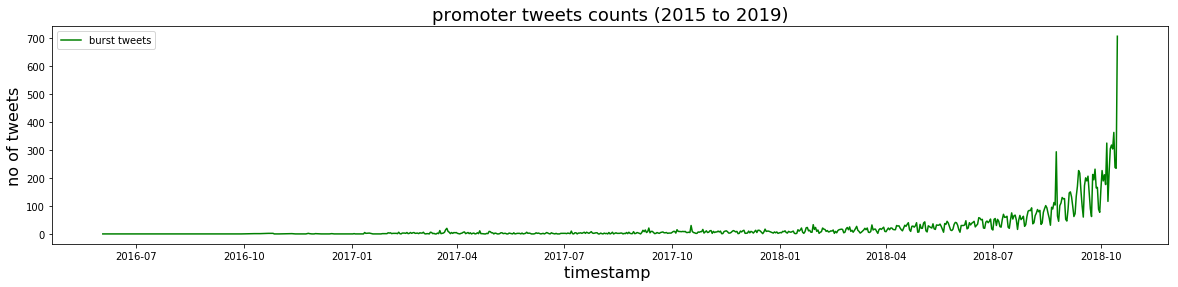

In [815]:
## find the occurance for both prom and nprom during the burst period.....
# plotting the tweet ids for prom and non prom
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(list(ds_promo.index),list(ds_promo['count']),color = 'green', label='burst tweets')
plt.ylabel("no of tweets",fontsize=16)
plt.xlabel("timestamp ", fontsize = 16)
plt.title("promoter tweets counts (2015 to 2019)",fontsize=18)
plt.legend()
plt.show() 

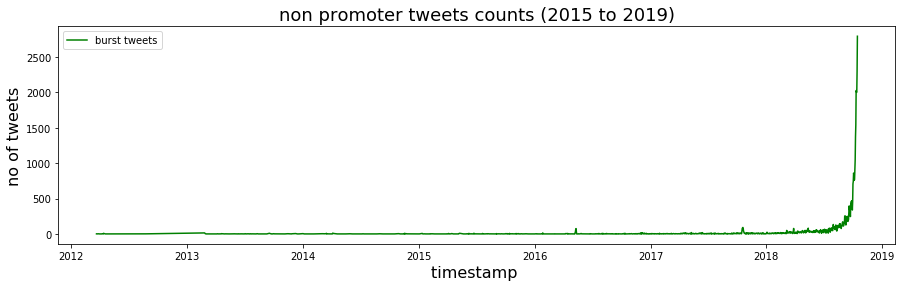

In [818]:
# plotting the tweet ids for prom and non prom
plt.rcParams["figure.figsize"] = (15,4)
plt.plot(list(ds_npromo.index),list(ds_npromo['count']),color = 'green', label='burst tweets')
plt.ylabel("no of tweets",fontsize=16)
plt.xlabel("timestamp ", fontsize = 16)
plt.title("non promoter tweets counts (2015 to 2019)",fontsize=18)
plt.legend()
plt.show() 

In [651]:
len(df_300.userID.unique())

300

## Pseudocode

In [643]:
# Pseudocode
# train the classifier on tweets D , sklearn logistic regression on that ...done that part
# priors user, url and burst ke aa gaye..based on model LR ..predict proba
# build the graph u-url-burst , weight based on propagation matrix e = some value...result based...
# for all edges..
## for all states of node 
##    Update the message passign info <- 1
# while not cnverged
#     for all edges in the graph
#         for all states of i
#             update the message passign info (uing eq 3 based on edge potential and node potential)
#         end for
#     end for
# end while

# calculate the final belief...
# Output the probability ...

In [712]:
# change the priors to include both class probablity..
# chane the edgelist with class probbilities

In [ ]:
# create the graph .. if poss can create in neo4j